<a href="https://colab.research.google.com/github/dapoarr/Projek-Capstone/blob/main/capstone_fake_review_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Deteksi Ulasan Palsu pada Aplikasi Mobile menggunakan Machine Learning



Ulasan pengguna di platform seperti Google Play Store sering digunakan calon pengguna untuk menentukan apakah suatu aplikasi layak diunduh atau tidak. Namun, banyaknya ulasan palsu menyebabkan bias penilaian. Proyek ini bertujuan untuk membangun model machine learning yang dapat mendeteksi apakah sebuah ulasan itu asli atau palsu.


- Mengumpulkan ulasan aplikasi dari Google Play Store.
- Melakukan preprocessing dan pelabelan dataset.
- Melatih model klasifikasi untuk deteksi fake review.
- Menyediakan API inferensi untuk pengujian ulasan.


## IMPORT LIBRARY

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix


import joblib


## 1. Akuisisi Data

Pada tahap ini, data ulasan akan dikumpulkan dari Google Play Store menggunakan `google-play-scraper`. Target awal adalah aplikasi `AdaKami-Pinjaman Uang Digital`. Data yang dikumpulkan mencakup isi ulasan dan skor rating dari pengguna.


In [ ]:
!pip install google_play_scraper

In [ ]:
# Import
from google_play_scraper import reviews, Sort

app_id = 'com.adakami.dana.kredit.pinjaman'

all_reviews = []
count = 0
limit = 11000  # jumlah ulasan yang diinginkan

while len(all_reviews) < limit:
    result, _ = reviews(
        app_id,
        lang='id',  # bahasa Indonesia
        country='id',  # dari Indonesia
        sort=Sort.NEWEST,
        count=500,  # ambil per batch
        filter_score_with=None
    )
    all_reviews.extend(result)
    count += 1
    print(f"Batch {count}: {len(all_reviews)} total reviews")

# Simpan dalam DataFrame
df = pd.DataFrame(all_reviews)
df = df[['content', 'score']]  # ambil kolom ulasan dan rating
df.columns = ['review', 'rating']

# Simpan ke CSV
df.to_csv('ulasan_adakami.csv', index=False)
df.head()

Batch 1: 500 total reviews
Batch 2: 1000 total reviews
Batch 3: 1500 total reviews
Batch 4: 2000 total reviews
Batch 5: 2500 total reviews
Batch 6: 3000 total reviews
Batch 7: 3500 total reviews
Batch 8: 4000 total reviews
Batch 9: 4500 total reviews
Batch 10: 5000 total reviews
Batch 11: 5500 total reviews
Batch 12: 6000 total reviews
Batch 13: 6500 total reviews
Batch 14: 7000 total reviews
Batch 15: 7500 total reviews
Batch 16: 8000 total reviews
Batch 17: 8500 total reviews
Batch 18: 9000 total reviews
Batch 19: 9500 total reviews
Batch 20: 10000 total reviews
Batch 21: 10500 total reviews
Batch 22: 11000 total reviews


,review,rating
0,proses cepat,5
1,saya sudah membayar angsuran saya tapi pihak d...,1
2,lama proses uang nya,1
3,Cepat Dan Terpercaya,5
4,bagus,3


## 2. Pra-pemrosesan Data

Tahap ini bertujuan untuk membersihkan data teks dari karakter yang tidak diperlukan, mengubah huruf menjadi huruf kecil, menghapus simbol, angka, dan stopwords agar siap digunakan dalam proses analisis sentimen. Kami menggunakan bahasa Indonesia sehingga kami juga akan menggunakan stopwords bahasa Indonesia.


In [ ]:
!pip install Sastrawi

In [ ]:
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# Load data
df = pd.read_csv('ulasan_adakami.csv')

# Inisialisasi stopwords bahasa Indonesia
factory = StopWordRemoverFactory()
stopwords_ind = factory.get_stop_words()

# Fungsi untuk preprocessing
def clean_text(text):
    # Ubah ke lowercase
    text = text.lower()
    # Hapus angka
    text = re.sub(r'\d+', '', text)
    # Hapus tanda baca
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Hapus whitespace
    text = text.strip()
    # Hapus stopwords
    text = ' '.join([word for word in text.split() if word not in stopwords_ind])
    return text

# Terapkan fungsi preprocessing
df['clean_review'] = df['review'].astype(str).apply(clean_text)

# Lihat hasil awal
df[['review', 'clean_review', 'rating']].head()


,review,clean_review,rating
0,proses cepat,proses cepat,5
1,saya sudah membayar angsuran saya tapi pihak d...,membayar angsuran pihak debt collector menghap...,1
2,lama proses uang nya,lama proses uang nya,1
3,Cepat Dan Terpercaya,cepat terpercaya,5
4,bagus,bagus,3


### Hasil Preprocessing

Tabel berikut menunjukkan perbandingan antara ulasan asli dan ulasan yang telah dibersihkan. Terlihat bahwa proses pembersihan teks menghilangkan angka, simbol, serta stopwords dalam bahasa Indonesia agar lebih fokus pada kata-kata penting untuk analisis sentimen.


## 3. Labeling Data Sentimen

Labeling dilakukan berdasarkan skor `rating` yang diberikan oleh pengguna terhadap aplikasi. Rentang penilaian antara 1 sampai 5 akan dikonversi menjadi 3 kelas sentimen:
- **1 dan 2** = Negatif (-1)
- **3**       = Netral (0)
- **4 dan 5** = Positif (1)

Label ini akan menjadi target (y) untuk model klasifikasi di tahap berikutnya.


In [ ]:
# Fungsi untuk mengubah rating menjadi label sentimen
def rating_to_sentiment(score):
    if score in [1, 2]:
        return -1  # Negatif
    elif score == 3:
        return 0   # Netral
    else:
        return 1   # Positif

# Terapkan ke kolom baru
df['sentiment'] = df['rating'].apply(rating_to_sentiment)

# Lihat distribusi label
df['sentiment'].value_counts()


,count
sentiment,
1,7788
-1,2882
0,330


### Distribusi Sentimen

Distribusi label hasil konversi rating ke sentimen ditampilkan sebagai berikut. Ini penting untuk mengetahui apakah data seimbang atau tidak antar kelas (positif, netral, negatif).


<ipython-input-13-e0d688f08faa>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='sentiment', palette='Set2')


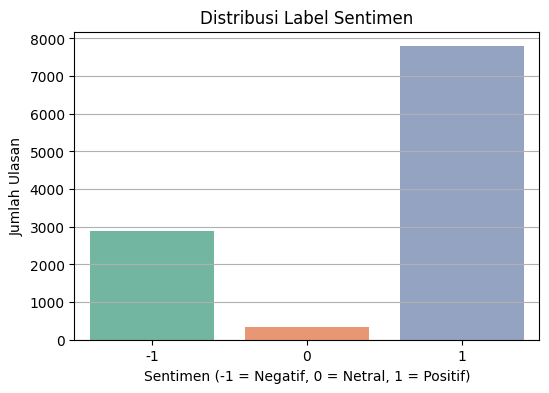

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='sentiment', palette='Set2')
plt.title("Distribusi Label Sentimen")
plt.xlabel("Sentimen (-1 = Negatif, 0 = Netral, 1 = Positif)")
plt.ylabel("Jumlah Ulasan")
plt.grid(axis='y')
plt.show()


## 4. Ekstraksi Fitur dengan TF-IDF

TF-IDF (Term Frequency - Inverse Document Frequency) adalah metode untuk merepresentasikan teks ke dalam bentuk vektor numerik berdasarkan seberapa penting kata tersebut dalam dokumen.

Semakin sering sebuah kata muncul dalam dokumen tertentu, dan semakin jarang kata tersebut muncul di dokumen lain, maka nilainya akan semakin tinggi.

Hasil dari TF-IDF ini akan menjadi fitur yang digunakan sebagai input untuk model klasifikasi.


In [ ]:
# Inisialisasi vectorizer
tfidf = TfidfVectorizer(max_features=5000)  # Bisa disesuaikan jumlah fiturnya

# Transformasi teks ke vektor TF-IDF
X = tfidf.fit_transform(df['review'])

# Target
y = df['sentiment']

# Tampilkan bentuk dari hasil transformasi
print("Shape fitur TF-IDF:", X.shape)


Shape fitur TF-IDF: (11000, 1118)


## 5. Pembuatan dan Evaluasi Model Machine Learning

Model klasifikasi digunakan untuk memprediksi sentimen dari ulasan pengguna aplikasi berdasarkan representasi numerik hasil TF-IDF.

Langkah-langkah:
1. Membagi data menjadi data latih dan data uji (train-test split).
2. Melatih model klasifikasi seperti Logistic Regression dan Multinomial Naive Bayes.
3. Mengukur performa model dengan metrik seperti akurasi, precision, recall, dan f1-score.


In [ ]:
# Split data menjadi train dan test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inisialisasi dan latih model
logreg = LogisticRegression(max_iter=1000)
nb = MultinomialNB()

logreg.fit(X_train, y_train)
nb.fit(X_train, y_train)

# Prediksi
y_pred_logreg = logreg.predict(X_test)
y_pred_nb = nb.predict(X_test)

# Evaluasi model
print("=== Logistic Regression ===")
print(classification_report(y_test, y_pred_logreg))
print("Akurasi:", accuracy_score(y_test, y_pred_logreg))

print("\n=== Multinomial Naive Bayes ===")
print(classification_report(y_test, y_pred_nb))
print("Akurasi:", accuracy_score(y_test, y_pred_nb))


=== Logistic Regression ===
              precision    recall  f1-score   support

          -1       1.00      0.96      0.98       566
           0       1.00      0.90      0.95        58
           1       0.98      1.00      0.99      1576

    accuracy                           0.99      2200
   macro avg       0.99      0.95      0.97      2200
weighted avg       0.99      0.99      0.99      2200

Akurasi: 0.9881818181818182

=== Multinomial Naive Bayes ===
              precision    recall  f1-score   support

          -1       0.98      0.95      0.97       566
           0       1.00      0.71      0.83        58
           1       0.97      0.99      0.98      1576

    accuracy                           0.98      2200
   macro avg       0.98      0.88      0.93      2200
weighted avg       0.98      0.98      0.97      2200

Akurasi: 0.9754545454545455


## 6. Penyimpanan Model Final

Model yang telah dilatih akan disimpan ke dalam file dengan format `.pkl` menggunakan library `joblib`. Penyimpanan ini memungkinkan model digunakan kembali tanpa perlu pelatihan ulang, terutama saat digunakan dalam proses deployment pada backend (API).


In [ ]:
import joblib

# Simpan model dan vectorizer ke dalam file
joblib.dump(logreg, 'model_sentimen_logreg.pkl')
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']

## 7. Fungsi Inferensi (Prediksi Sentimen)

Setelah model dan vectorizer disimpan, dibuat fungsi inferensi sederhana untuk memprediksi sentimen dari input teks. Fungsi ini akan mengambil input kalimat, melakukan transformasi TF-IDF, lalu memprediksi kelas menggunakan model klasifikasi.


In [ ]:
# Fungsi prediksi sentimen
def prediksi_sentimen(teks):
    # Load model dan vectorizer jika belum ada di memori
    model = joblib.load('model_sentimen_logreg.pkl')
    vectorizer = joblib.load('tfidf_vectorizer.pkl')

    # Transformasi input teks
    teks_vectorized = vectorizer.transform([teks])

    # Prediksi
    prediksi = model.predict(teks_vectorized)[0]

    # Label interpretasi
    if prediksi == 1:
        hasil = "Positif"
    else:
        hasil = "Negatif"

    return hasil


In [ ]:
# Contoh uji coba fungsi prediksi
contoh_ulasan = "Aplikasinya sangat membantu dan prosesnya cepat sekali!"
print(f"Ulasan: {contoh_ulasan}")
print("Prediksi Sentimen:", prediksi_sentimen(contoh_ulasan))


Ulasan: Aplikasinya sangat membantu dan prosesnya cepat sekali!
Prediksi Sentimen: Positif
